<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/LLaVa/Inference_with_LLaVa_for_multimodal_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%ls

drive/  sample_data/


In [ ]:
%cd drive/MyDrive/SketchToReality/

/content/drive/MyDrive/SketchToReality


In [ ]:
%ls

Articles/  Data/  Dataset/  data_viusalization_colab.ipynb  utils/


# Inference with LLaVa, a multimodal LLM

LLaVa is an exciting new multimodal LLM which extends large language models like [LLaMa](https://huggingface.co/docs/transformers/model_doc/llama) with visual inputs.

For multimodal LLMs, one typically takes a pre-trained/fine-tuned LLM and additionally conditions it on image features. In case of LLaVa, the image features come from a pre-trained [CLIP](https://huggingface.co/docs/transformers/model_doc/clip)'s vision encoder. To match the dimension of the image features with those of the text features, one applies a projection module, which could be a simple linear projection (like the original LLaVa), or more sophisticated like a two-layer MLP (used in LLaVa 1.5).

One then trains the model to predict the next text token, given image features and text tokens.

![image/png](https://cdn-uploads.huggingface.co/production/uploads/62441d1d9fdefb55a0b7d12c/FPshq08TKYD0e-qwPLDVO.png)

* Transformers docs: https://huggingface.co/docs/transformers/main/en/model_doc/llava.
* Original LLaVa paper: https://arxiv.org/abs/2304.08485
* LLaVa 1.5 paper: https://arxiv.org/pdf/2310.03744.pdf
* [notebook](https://colab.research.google.com/drive/1qsl6cd2c8gGtEW1xV5io7S8NHh-Cp1TV?usp=sharing#scrollTo=6Bx8iu9jOssW) which inspired me to create this notebook.

## Set-up environment

Let's start by installing the necessary libraries. Here we install Accelerate and Bitsandbytes in order to load the model in Google Colab. This enables [4-bit inference](https://huggingface.co/blog/4bit-transformers-bitsandbytes) with clever quantization techniques, shrinking the size of the model considerably, while maintaining performance of the original size.

In [ ]:
!pip install --upgrade -q accelerate bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 2.2 MB/s eta 0:00:00


We also update the Transformers version of Google Colab to use the main branch, as the model is brand new at the time of writing.

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-ok6wih0q
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-ok6wih0q
  Resolved https://github.com/huggingface/transformers.git to commit 2209b7afa04b3a6366350065f541e9248d6663c2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.39.0.dev0-py3-none-any.whl size=8593669 sha256=f2953babdb74feb5593e8ffa8b9ed9ca804aace669860f2b0820aeac6eaa7827
  Stored in directory: /tmp/pip-ephem-wheel-cache-ij1jr236/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.37.2
    Uninstalling transformers-4.37.2:
      Successfully uninstalled transformers-4.37.2


## Load model and processor

Next, we load a model and corresponding processor from the hub. We specify device_map="auto" in order to automatically place the model on the available GPUs/CPUs (see [this guide](https://huggingface.co/docs/accelerate/usage_guides/big_modeling) for details).

Regarding [quantization](https://huggingface.co/blog/4bit-transformers-bitsandbytes), refer to the blog post for all details.

In [ ]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import BitsAndBytesConfig
import torch

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)


model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id, quantization_config=quantization_config, device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Prepare image and text for the model

In [ ]:
from PIL import Image
import os
import numpy as np
import glob

sketch_path = './Data/data/sketch/tx_000000000000/*/*'
list_all_files = []
for file in glob.glob(sketch_path, recursive=True):
    list_all_files.append(file)

Label: pretzel


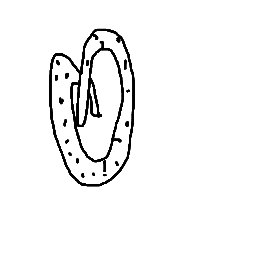

In [ ]:
random_sketch_idx = np.random.randint(0, len(list_all_files))
random_sketch_path = list_all_files[random_sketch_idx]
label = random_sketch_path.split(sep='/')[-2]
RandomSketch = Image.open(random_sketch_path)
print(f'Label: {label}')
display(RandomSketch)

In the prompt, you can refer to images using the special \<image> token. To indicate which text comes from a human vs. the model, one uses USER and ASSISTANT respectively. The format looks as follows:

```bash
USER: <image>\n<prompt>\nASSISTANT:
```

In other words, you always need to end your prompt with `ASSISTANT:`. Here we will perform batched generation (i.e generating on several prompts).

In [ ]:
prompts = [
            "USER: <image>\nWhat is drawn in this art sketch?\nASSISTANT:",
            "USER: <image>\nWhat is drawn in this art sketch ? And what is the view point of this subject ?\nASSISTANT:",
            "USER: <image>\nWhat is drawn in this art sketch ? Is it in a particular pose ?\nASSISTANT:",
            "USER: <image>\nWhat is drawn in this art sketch ? What are the specific features of this subject (pose, where is it viewed from, sub-category, ...) ?\nASSISTANT:",
]

# Input as many prompts as images (does not automatically scale)
inputs = processor(prompts, images=[RandomSketch, RandomSketch, RandomSketch, RandomSketch], padding=True, return_tensors="pt").to("cuda")
for k,v in inputs.items():
  print(k,v.shape)

input_ids torch.Size([4, 44])
attention_mask torch.Size([4, 44])
pixel_values torch.Size([4, 3, 336, 336])


## Autoregressively generate completion

Finally, we simply let the model predict the next tokens given the images + prompt. Of course one can adjust all the [generation parameters](https://huggingface.co/docs/transformers/v4.35.2/en/main_classes/text_generation#transformers.GenerationMixin.generate). By default, greedy decoding is used.

In [ ]:
output = model.generate(**inputs, max_new_tokens=100)
generated_text = processor.batch_decode(output, skip_special_tokens=True) # Greedy decoding
for text in generated_text:
  print(text.split("ASSISTANT:")[-1])

 In this art sketch, a large, black, and white donut is drawn.
 In this art sketch, a large, black, and white donut is drawn. The view point of the subject is from the top, as the donut is depicted from above. This perspective creates a sense of depth and adds an interesting visual element to the artwork.
 In the art sketch, a large black circle is drawn. It is not in a particular pose, but rather a simple, abstract representation of a circle. The circle is the main focus of the artwork, and it is not depicted in any specific action or pose.
 In this art sketch, a black and white drawing of a horseshoe is created. The horseshoe is viewed from the side, and it is a simple, minimalistic representation of the subject. The specific features of this subject include the shape of the horseshoe, the black and white color scheme, and the perspective from which it is viewed.


## Evaluating on a batch of images to evaluate Llava

We first create some evaluation metrics. We will use:
- Label accuracy: if the class label was found
- Length: length of the produced answer
- Complexity: Yngve measure of the produced caption. It computes the number of independent propositions in the caption.

In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk.tree import Tree
from nltk.corpus import treebank
# Download the necessary resources for NLTK
nltk.download('treebank')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
# Function to calculate the Yngve Measure
def yngve_measure(sentence):
    # Tokenize the sentence
    tokens = nltk.word_tokenize(sentence)

    # Perform part-of-speech tagging
    pos_tags = nltk.pos_tag(tokens)

    # Define a grammar for parsing
    grammar = nltk.CFG.fromstring("""
    S -> NP VP | NP VP PP | NP VP ADJP | NP VP NP | VP NP | VP VP | VP ADJP | VP PP
    NP -> DT NN | PRP | NN | NNP | PRP NN | DT JJ NN
    VP -> VBZ | VBD | VBN | VBG | VBP | VB NP | VB NP PP | VB NP NP
    PP -> IN NP
    ADJP -> JJ
    """)

    # Create a parser
    parser = nltk.ChartParser()

    # Parse the sentence
    parses = parser.parse(pos_tags)

    # Get the first parse tree
    parse_tree = next(parses)

    # Calculate the depth of the parse tree
    depth = parse_tree.height()

    return depth

# Example sentences
sentences = [
    "The cat sat on the mat.",
    "The quick brown fox jumps over the lazy dog.",
    "I saw a man with a telescope.",
    "She is eating an apple.",
    "He gave me a book."
]

# Calculate Yngve Measure for each sentence
for sentence in sentences:
    yngve = yngve_measure(sentence)
    print(f"Yngve Measure for '{sentence}': {yngve}")

TypeError: ChartParser.__init__() missing 1 required positional argument: 'grammar'

In [ ]:
# # Transform batch of image of our dataset to list to feed to Llava

# def batch_toPILlist(batch, dataset, show_batch = True): # batch is a list of tensors
#     topil = transforms.ToPILImage()
#     classes = dataset.classes
#     PIL_list = []
#     labels = []
#     for i in range(len(batch[0])):
#         image = batch[0][i].cpu().numpy()
#         image = image.transpose((1, 2, 0))
#         image = (image * 255.0).astype("uint8")
#         PILimage = topil(image)
#         # grab the label id and get the label from the classes list
#         idx = batch[1][i]
#         label = classes[idx] # In the DataLoader class
#         PIL_list.append(PILimage)
#         labels.append(label)

#     if show_batch:
#         visualize_batch(batch, classes, "")
#     return PIL_list, labels

Let's compute the measure on our evaluation set

In [1]:
import pandas as pd
def dataframe_toPILlist(df, show_img = False):
    image_list = []
    label_list = []
    for i in range(df.shape[0]):
        row = df.iloc[i]
        path = row['path']
        lab = row['label']

        img = Image.open(path)
        image_list.append(img)
        label_list.append(lab)

        if show_img:
            print(f'\nLabel {lab}')
            display(img)

    return image_list, label_list


Label car_(sedan)


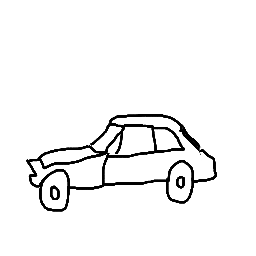


Label bicycle


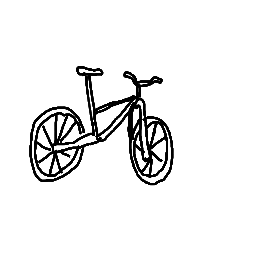


Label ape


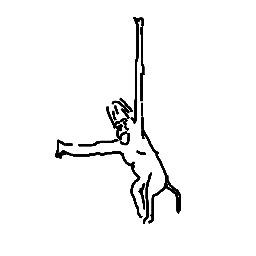


Label racket


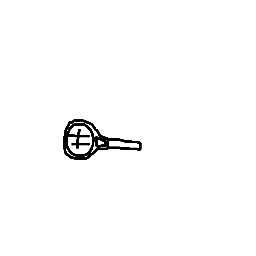


Label windmill


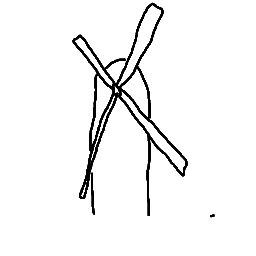


Label rifle


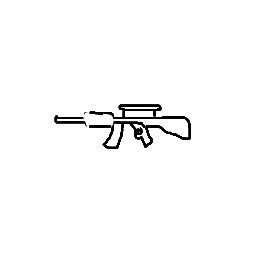


Label dolphin


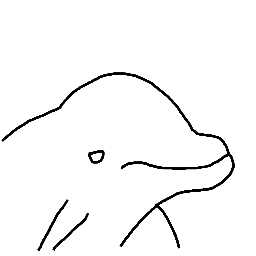


Label fan


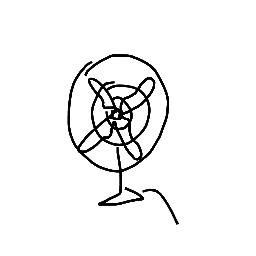


Label giraffe


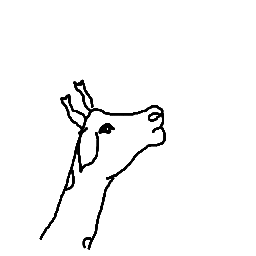


Label cat


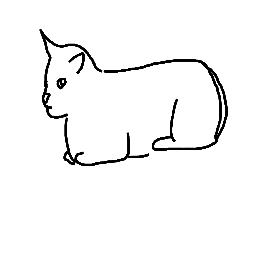


Label cat


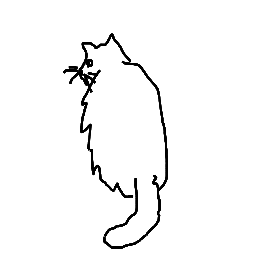


Label violin


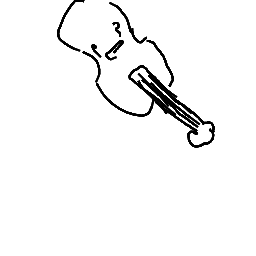


Label pretzel


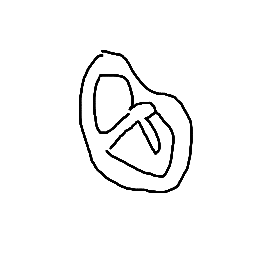


Label teddy_bear


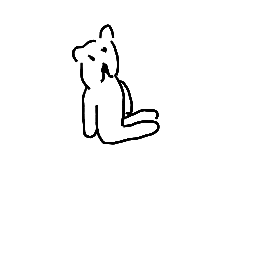


Label sword


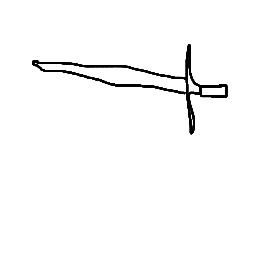


Label dog


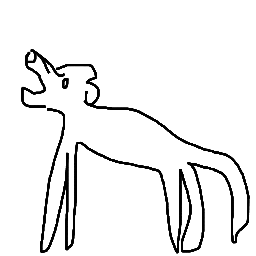


Label castle


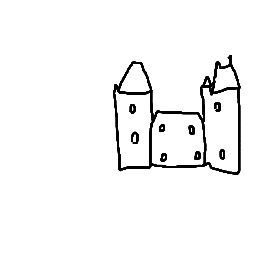


Label hamburger


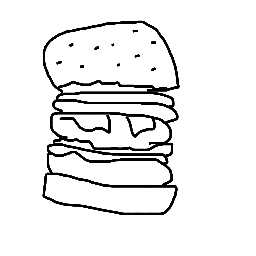


Label frog


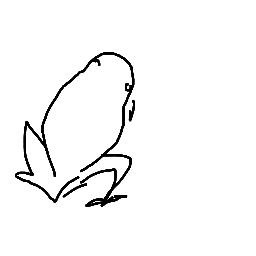


Label hamburger


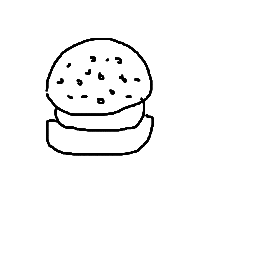


Label hat


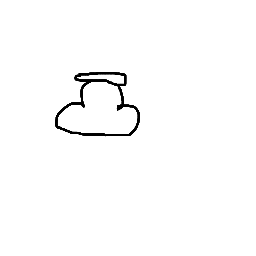


Label crab


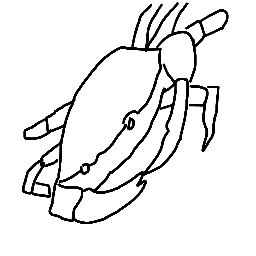


Label raccoon


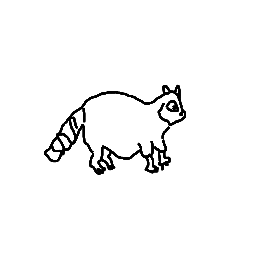


Label alarm_clock


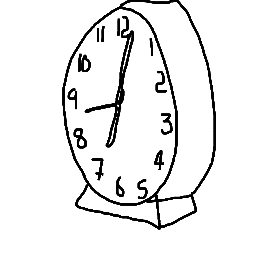


Label candle


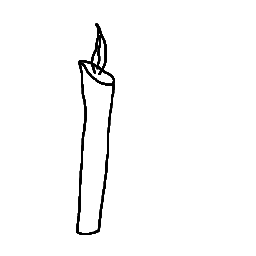


Label bell


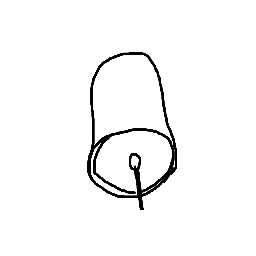


Label helicopter


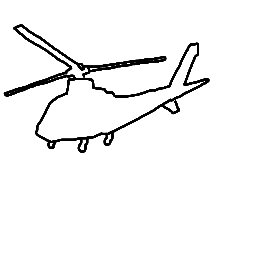


Label raccoon


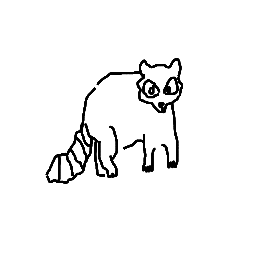


Label banana


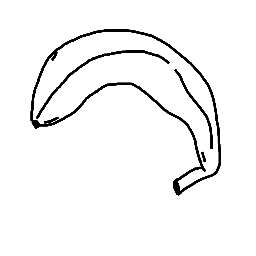


Label cow


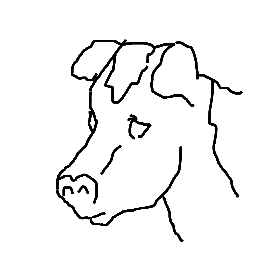


Label duck


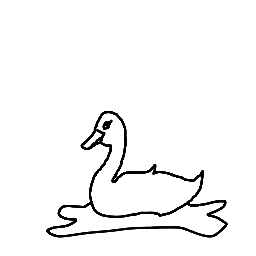


Label window


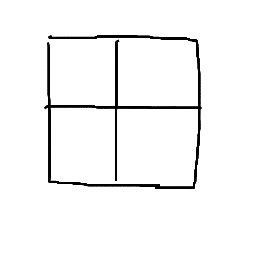


Label blimp


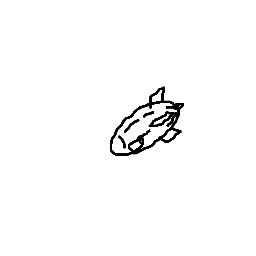


Label alarm_clock


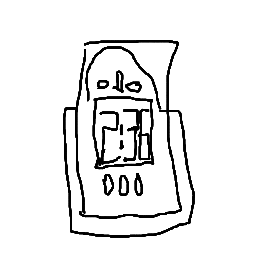


Label rhinoceros


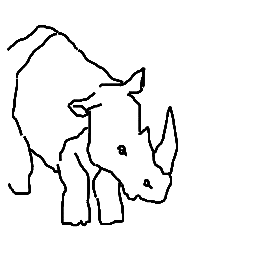


Label trumpet


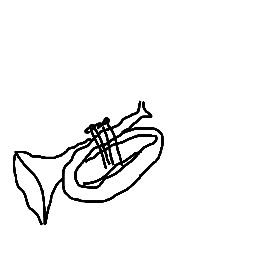


Label armor


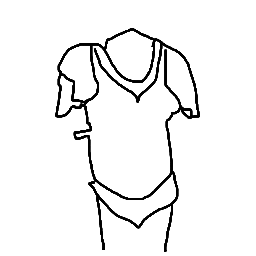


Label ant


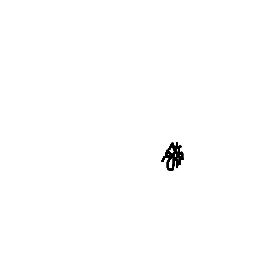


Label snail


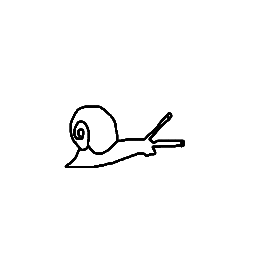


Label jellyfish


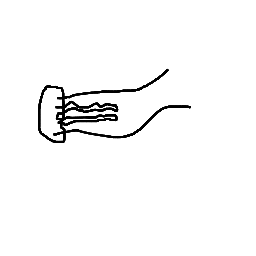


Label deer


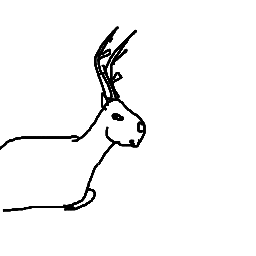


Label tree


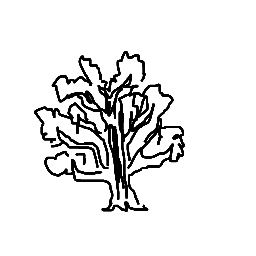


Label bench


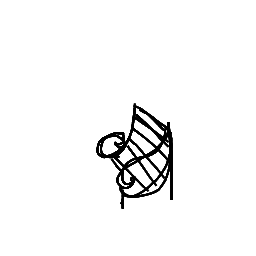


Label wheelchair


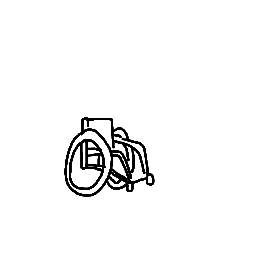


Label fan


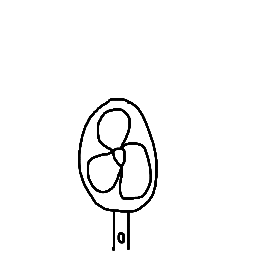


Label strawberry


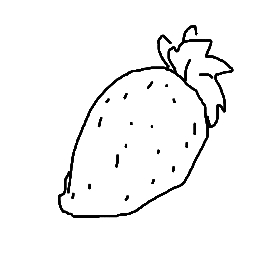


Label shark


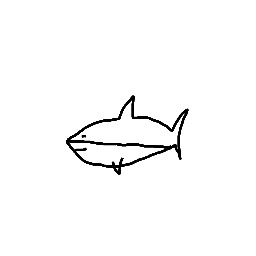


Label duck


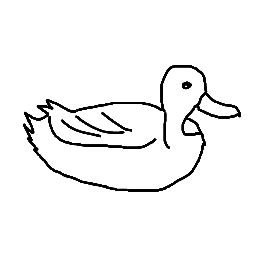


Label candle


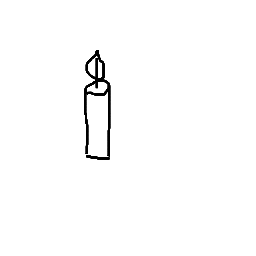


Label deer


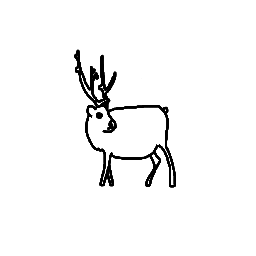


Label pretzel


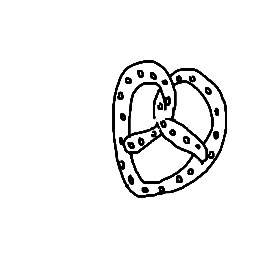


Label scorpion


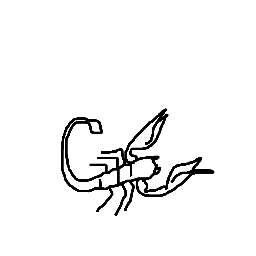


Label bear


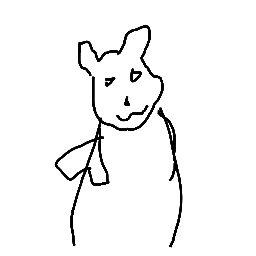


Label cannon


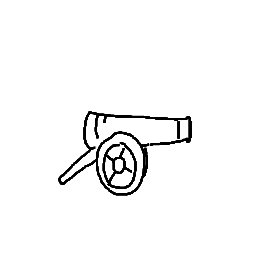


Label helicopter


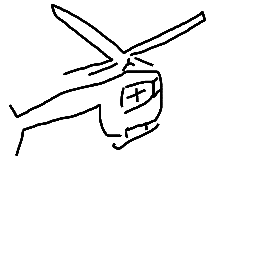


Label pineapple


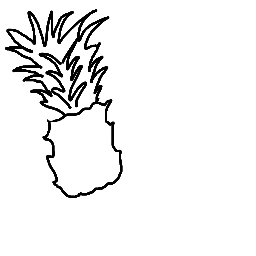


Label ape


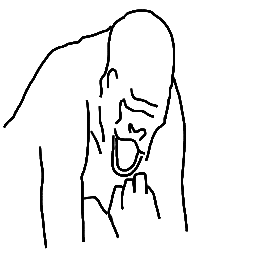


Label hedgehog


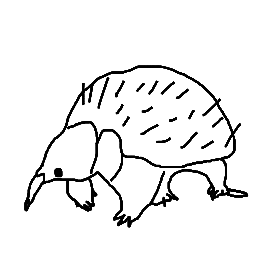


Label snake


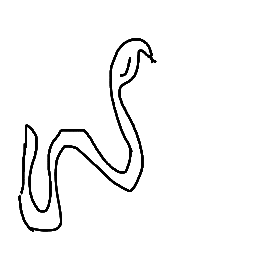


Label umbrella


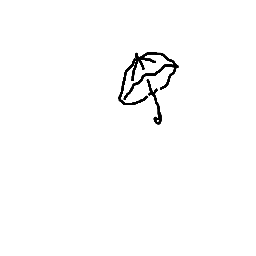


Label windmill


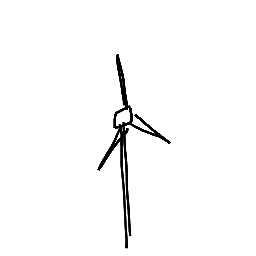


Label hamburger


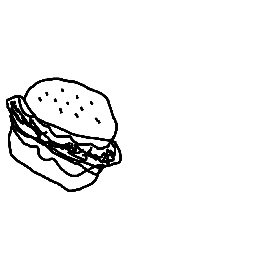


Label piano


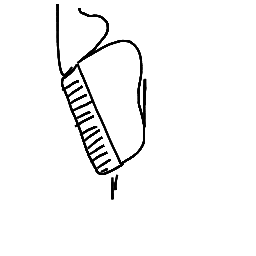


Label duck


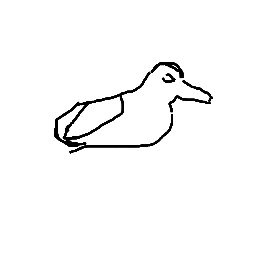


Label camel


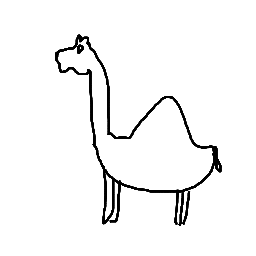


Label bicycle


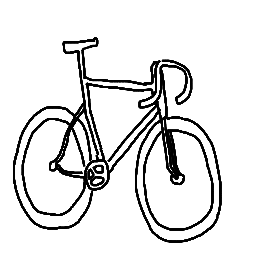


Label church


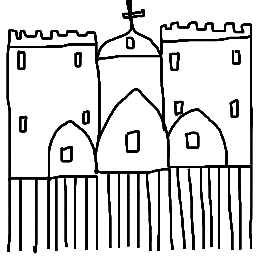


Label shoe


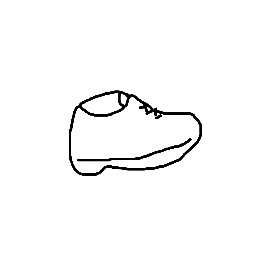


Label skyscraper


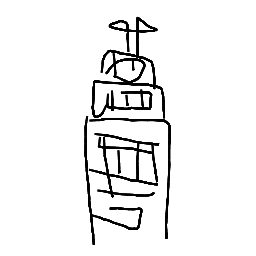


Label geyser


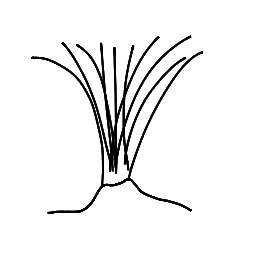


Label fan


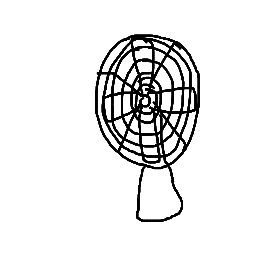


Label butterfly


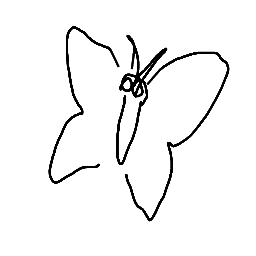


Label deer


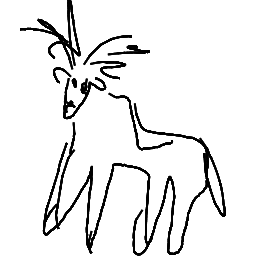


Label chair


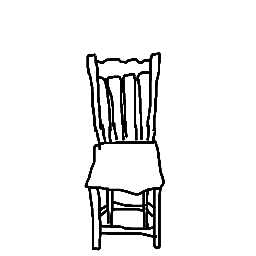


Label windmill


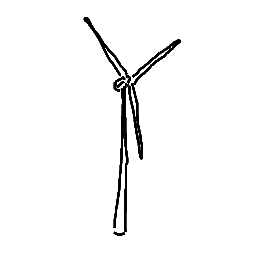


Label squirrel


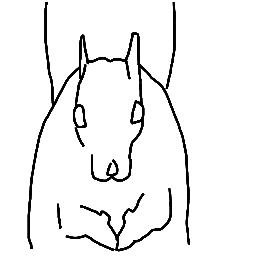


Label jellyfish


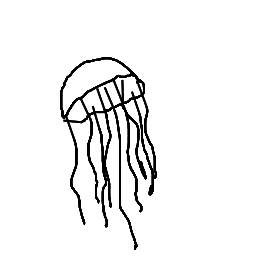


Label flower


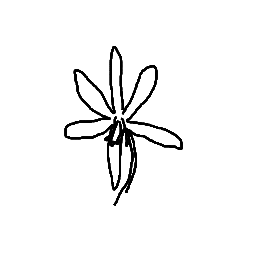


Label apple


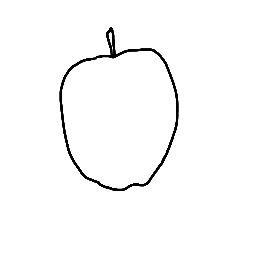


Label sword


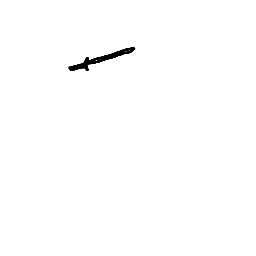


Label sword


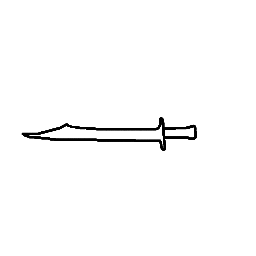


Label banana


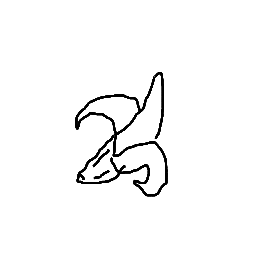


Label motorcycle


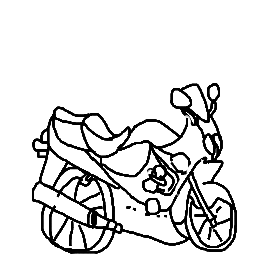


Label squirrel


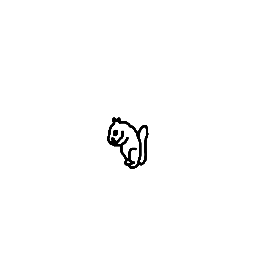


Label sailboat


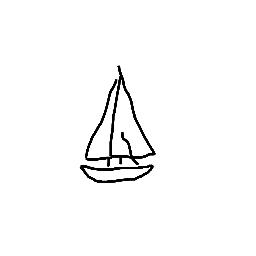


Label hot-air_balloon


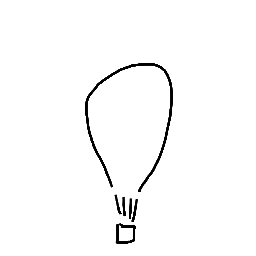


Label ray


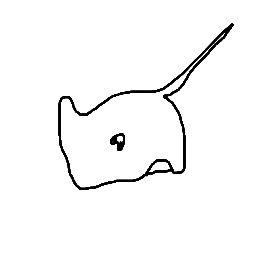


Label butterfly


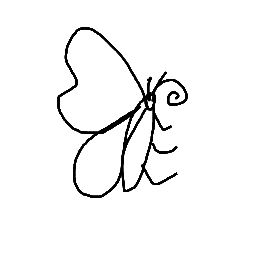


Label bell


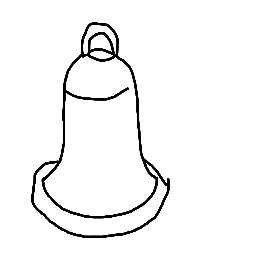


Label owl


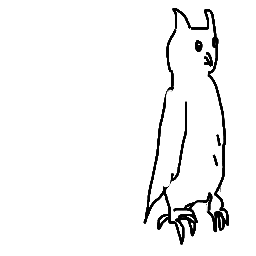


Label banana


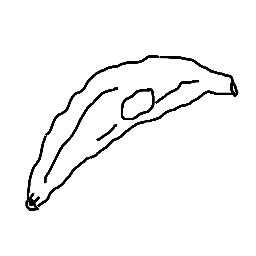


Label tree


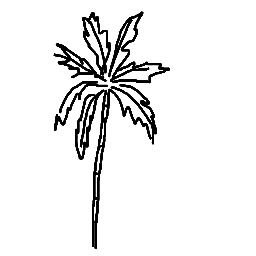


Label starfish


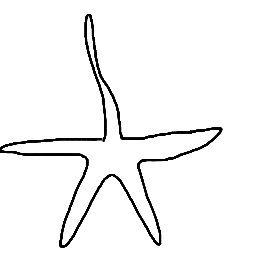


Label pig


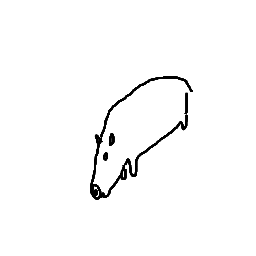


Label bench


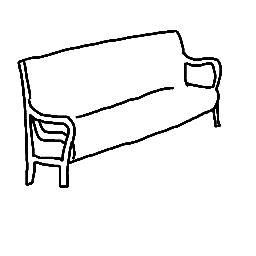


Label sword


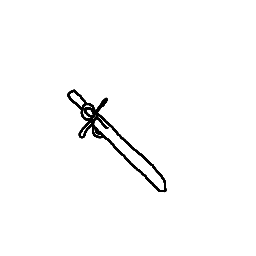


Label bicycle


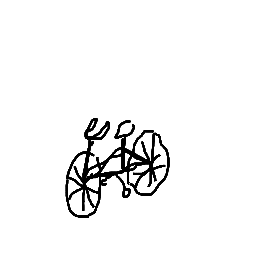


Label airplane


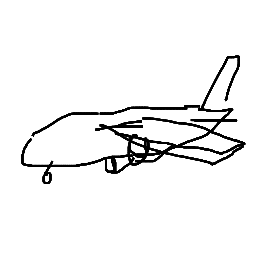


Label duck


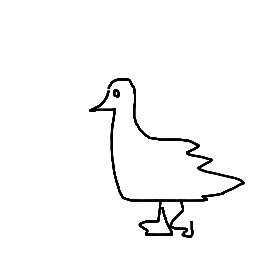


Label mouse


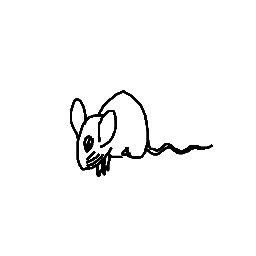

In [ ]:
eval_file = './Data/data/sketch/eval_image_captioning.csv'
eval_dataframe = pd.read_csv(eval_file)
PILimages, labels = dataframe_toPILlist(eval_dataframe, show_img=True)

In [ ]:
def evaluate_llava(img_list, label_list, eval_prompt = ["USER: <image>\nWhat is drawn in this art sketch?\nASSISTANT:"], metrics = ['accuracy', 'length'], display = False):

  results = {metric: [] for metric in metrics}
  if len(eval_prompt) > 1:
    print("For evaluation, please input only 1 prompt to check if label is in the generated answer")
    return 0

  for i in range(len(img_list)):
    sketch = [img_list[i]]
    label = label_list[i]
    # Input as many prompts as images (does not automatically scale)
    inputs = processor(eval_prompt, images=sketch, padding=True, return_tensors="pt").to("cuda")
    output = model.generate(**inputs, max_new_tokens=100)
    generated_text = processor.batch_decode(output, skip_special_tokens=True) # Greedy decoding
    for text in generated_text:
      answer = text.split("ASSISTANT:")[-1]

    if(display):
      display(sketch[0])
    if 'accuracy' in metrics:
      if label in answer:
        results['accuracy'].append(1)
        if(display):
          print(f'\nLabel {label} found in answer:{answer}')
      else:
        results['accuracy'].append(0)
        if(display):
          print(f'\nLabel {label} not found in answer:{answer}')

    if 'length' in metrics:
      results['length'].append(len(answer))

  print(f'Final Results:\n')
  if 'accuracy' in metrics:
    acc = np.mean(results['accuracy'])
    print(f'Accuracy of Llava1.5: {acc}')
  if 'length' in metrics:
    avg_length = np.mean(results['length'])
    print(f'Average Length of Llava1.5: {avg_length}')
  return results

In [ ]:
accuracy_llava = evaluate_llava(PILimages, labels)


Label car_(sedan) not found in answer: In this art sketch, a car is drawn.

Label bicycle found in answer: In this art sketch, a bicycle is drawn.

Label ape not found in answer: In this art sketch, a person is depicted holding a stick or a pole. The person is wearing a hat and appears to be a naked figure. The drawing is a simple, black and white sketch, which highlights the contrast between the figure and the background.

Label racket not found in answer: In this art sketch, a magnifying glass is drawn.

Label windmill found in answer: In this art sketch, a windmill is drawn.

Label rifle not found in answer: In this art sketch, a gun is drawn.

Label dolphin found in answer: In this art sketch, a dolphin is drawn.

Label fan found in answer: In this art sketch, a fan or a propeller is drawn. The fan is shown with its blades, and it appears to be a simple, black and white drawing. The focus of the sketch is on the fan, with no other objects or elements visible in the image.

Label g

In [ ]:
prompts = ["USER: <image>\nWhat is drawn in this art sketch ? And what is the view point of this subject ?\nASSISTANT:",
            "USER: <image>\nWhat is drawn in this art sketch ? Is it in a particular pose ?\nASSISTANT:",
            "USER: <image>\nWhat is drawn in this art sketch ? What are the specific features of this subject (pose, where is it viewed from, sub-category, ...) ?\nASSISTANT:",
            "USER: <image>\nProvide a detailed description of the viewpoint and pose depicted in this sketch, including any unique angles or perspectives.\nASSISTANT:",
            "USER: <image>\nWhat is drawn in this art sketch ? Provide a detailed description of the viewpoint and pose depicted in this sketch, including any unique angles or perspectives.\nASSISTANT:",
            "USER: <image>\nWhat is drawn in this art sketch ? Describe the main features and style of this sketch, including viewpoint, pose, and any notable characteristics.\nASSISTANT:",
            "USER: <image>\nOffer a narrative interpretation of this sketch, considering its context, mood, and potential symbolic meanings beyond simple object recognition.\nASSISTANT:"
            ]

comparative_prompt = ["USER: <image>\nCompare and contrast this sketch with other works in the same category, highlighting unique stylistic choices, thematic elements, or narrative approaches.\nASSISTANT:"]

for prompt in prompts:
  print(f'\nEvaluating Prompt: {prompt}')
  evaluate_llava(PILimages, labels, eval_prompt=[prompt])


Evaluating Prompt: USER: <image>
What is drawn in this art sketch ? And what is the view point of this subject ?
ASSISTANT:
Final Results:

Accuracy of Llava1.5: 0.55
Average Length of Llava1.5: 260.71

Evaluating Prompt: USER: <image>
What is drawn in this art sketch ? Is it in a particular pose ?
ASSISTANT:
Final Results:

Accuracy of Llava1.5: 0.51
Average Length of Llava1.5: 311.61

Evaluating Prompt: USER: <image>
What is drawn in this art sketch ? What are the specific features of this subject (pose, where is it viewed from, sub-category, ...) ?
ASSISTANT:
Final Results:

Accuracy of Llava1.5: 0.57
Average Length of Llava1.5: 322.31

Evaluating Prompt: USER: <image>
Provide a detailed description of the viewpoint and pose depicted in this sketch, including any unique angles or perspectives.
ASSISTANT:
Final Results:

Accuracy of Llava1.5: 0.59
Average Length of Llava1.5: 402.77

Evaluating Prompt: USER: <image>
What is drawn in this art sketch ? Provide a detailed description of

Based on these quantitative measures, we select only 3 prompts for which we will inspect the answers to give a qualitative appreciation and select the best prompt

In [ ]:
# Save function

def save_prompt_answer(imgs_name, label_list, prompt_list, answer_list, path = './test.csv'):
    try:
        folder_path = path.split('/')[-2]
    except:
        print('Invalid path to save data')
        return None

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    df_dict = {'ImageName': imgs_name, "Labels": label_list, "Prompts": prompt_list, 'Answers':answer_list}
    df = pd.DataFrame.from_dict(df_dict)
    df.to_csv(path, index=False)
    print(f'Saved answers at {path}')
    return df

In [ ]:
def generate_save_prompt_answers(csv_eval, eval_prompt, path_name = './results/results.csv')

  eval_dataframe = pd.read_csv(csv_eval)
  path_names = eval_dataframe['path']
  image_names = [s.split('/')[-1] for s in path_names]
  img_list, label_list = dataframe_toPILlist(eval_dataframe, show_img=True)
  prompt_list = [eval_prompt]*len(img_list)

  answers = []
  for i in range(len(img_list)):
    sketch = [img_list[i]]
    label = label_list[i]

    inputs = processor(eval_prompt, images=sketch, padding=True, return_tensors="pt").to("cuda")
    output = model.generate(**inputs, max_new_tokens=100)
    generated_text = processor.batch_decode(output, skip_special_tokens=True) # Greedy decoding
    for text in generated_text:
      answer = text.split("ASSISTANT:")[-1]
      answers.append(answer)

    if(display):
      print(f'Label {label}')
      display(sketch[0])
      print(f'Answer{answer}')


  results_dataframe = save_prompt_answer(image_names, label_list, prompt_list, answers, path = path_name)
  return results_dataframe

In [ ]:
prompts = { 'prompt1':"USER: <image>\nWhat is drawn in this art sketch ? What are the specific features of this subject (pose, where is it viewed from, sub-category, ...) ?\nASSISTANT:",
            'prompt2':"USER: <image>\nProvide a detailed description of the viewpoint and pose depicted in this sketch, including any unique angles or perspectives.\nASSISTANT:",
            'prompt3':"USER: <image>\nOffer a narrative interpretation of this sketch, considering its context, mood, and potential symbolic meanings beyond simple object recognition.\nASSISTANT:"
}

# Generating and saving for eval.csv on prompts indicated above
eval_file = './Data/data/sketch/eval_image_captioning.csv'

for p_name, prompt in prompts.items():
  print(f'\nWriting answer for {p_name}: {prompt}')
  generate_save_prompt_answers(eval_file, eval_prompt=[prompt], path_name = f'./results/res_{p_name}.csv')

In [6]:
prompt1_df = pd.read_csv('./results/res_prompt1.csv')
labanswers = prompt1_df[['Labels', 'Answers']]
labanswers

,Labels,Answers
0,car_(sedan),"In this art sketch, a car is drawn. The speci..."
1,bicycle,"The art sketch features a bicycle, which is a..."
2,ape,"The art sketch features a naked figure, possi..."
3,racket,"In the art sketch, a magnifying glass is draw..."
4,windmill,"In the art sketch, a windmill is drawn. The s..."
...,...,...
95,sword,"In the art sketch, a sword is drawn. The spec..."
96,bicycle,"The art sketch features a bicycle, which is a..."
97,airplane,"In this art sketch, a large jet airplane is d..."
98,duck,"In this art sketch, a duck is drawn. The spec..."


In [10]:
for i in range(labanswers.shape[0]):
    label = labanswers.iloc[i][0]
    answer = labanswers.iloc[i][1]
    print(f'Label {label}')
    print(answer)
    print('________________________________________________________')

Label car_(sedan)
 In this art sketch, a car is drawn. The specific features of the car include its make, model, and color. The car is viewed from the front, and it is a two-door car. The sketch also includes a wheel, which is a part of the car's overall design.
________________________________________________________
Label bicycle
 The art sketch features a bicycle, which is a two-wheeled vehicle powered by pedaling. The bicycle is drawn in black and white, giving it a classic and timeless appearance. The specific features of the bicycle include the handlebars, which are the controls used to steer the bike, and the spokes, which are the metal components that hold the wheels together. The bicycle is viewed from the side, showcasing
________________________________________________________
Label ape
 The art sketch features a naked figure, possibly a man, with a staff in his hand. The figure is viewed from the side, and it appears to be a drawing of a person in a specific pose. The subje

In [12]:
prompt2_df = pd.read_csv('./results/res_prompt2.csv')
labanswers = prompt2_df[['Labels', 'Answers']]
for i in range(labanswers.shape[0]):
    label = labanswers.iloc[i][0]
    answer = labanswers.iloc[i][1]
    print(f'Label {label}')
    print(answer)
    print('________________________________________________________')

Label car_(sedan)
 The sketch depicts a side view of a car, with the car's front end facing the viewer. The car is shown in a black and white color scheme, giving it a classic and timeless appearance. The perspective of the sketch is from the side, allowing the viewer to see the car's profile and its various components, such as the hood, grille, and headlights. The car's position in the sketch is slightly tilted, giving
________________________________________________________
Label bicycle
 The sketch depicts a black and white image of a bicycle, showcasing the front wheel and handlebars. The bicycle is positioned in a way that it appears to be ridden by a person, with the handlebars and front wheel being the main focus. The unique angle and perspective of the sketch emphasize the details of the bicycle, making it an interesting and artistic representation of the subject.
________________________________________________________
Label ape
 The sketch depicts a unique viewpoint and pose 

In [13]:
prompt3_df = pd.read_csv('./results/res_prompt3.csv')
labanswers = prompt3_df[['Labels', 'Answers']]
for i in range(labanswers.shape[0]):
    label = labanswers.iloc[i][0]
    answer = labanswers.iloc[i][1]
    print(f'Label {label}')
    print(answer)
    print('________________________________________________________')

Label car_(sedan)
 The image features a black and white sketch of a car, possibly a vintage or classic model. The car is the main focus of the sketch, with its shape and details captured in the drawing. The monochrome color scheme adds a sense of nostalgia and timelessness to the scene.

The car could symbolize freedom, adventure, or even a sense of escape from everyday life. It might also represent the journey of exploration, as people often embark
________________________________________________________
Label bicycle
 The image features a black and white sketch of a bicycle, with the bicycle's wheel prominently displayed. The sketch appears to be a simple, minimalist representation of the bicycle, possibly emphasizing the form and structure of the bike rather than its color or intricate details. The monochrome color scheme adds a sense of timelessness and classic elegance to the image.

In terms of mood, the sketch might evoke feelings of
_____________________________________________